#Import packages 

In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Activation, Dense, Dropout, Conv1D, Flatten, MaxPooling1D , Conv2D, MaxPooling2D

from keras.models import Sequential

import librosa

import librosa.display

import numpy as np

import pandas as pd

import random

import matplotlib.pyplot as plt

import csv

%matplotlib inline

import os

import warnings
warnings.filterwarnings('ignore')


#Load Data Method 1 

In [2]:
!curl -O http://storage.googleapis.com/eu_audioset/youtube_corpus/v1/features/features.tar.gz
!curl -O http://storage.googleapis.com/eu_audioset/youtube_corpus/v1/csv/class_labels_indices.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2468M  100 2468M    0     0  14.0M      0  0:02:56  0:02:56 --:--:-- 14.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14675  100 14675    0     0  36504      0 --:--:-- --:--:-- --:--:-- 36504


#Extracting tfRecods files

In [3]:
!tar xvfz features.tar.gz | wc -l

12232


#Parsing the csv file with the names of the labels

In [4]:
with open('class_labels_indices.csv', encoding='utf-8') as class_map_csv:
  class_names = [display_name for (class_index, mid, display_name) in csv.reader(class_map_csv)]
  class_names = class_names[1:]  # Skips the CSV header

class_names = np.array(class_names)

#Reading tfrecord data


In [5]:
tfrecord_files = os.listdir('audioset_v1_embeddings/bal_train/')
raw_dataset = tf.data.TFRecordDataset([os.path.join('audioset_v1_embeddings/bal_train/', f) for f in tfrecord_files])

for raw_record in raw_dataset.take(1):
  tf_seq_example = tf.train.SequenceExample()
  tf_seq_example.ParseFromString(raw_record.numpy())
  print(tf_seq_example)


context {
  feature {
    key: "end_time_seconds"
    value {
      float_list {
        value: 60.0
      }
    }
  }
  feature {
    key: "labels"
    value {
      int64_list {
        value: 137
        value: 138
        value: 219
        value: 505
      }
    }
  }
  feature {
    key: "start_time_seconds"
    value {
      float_list {
        value: 50.0
      }
    }
  }
  feature {
    key: "video_id"
    value {
      bytes_list {
        value: "oPiyXhxRGe4"
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "audio_embedding"
    value {
      feature {
        bytes_list {
          value: "\204\303q\032\331;H\025\003\205\265n8t\253\177\000\000\340p=\221H\000tF\240\177\313\235`\200\224\325:\356\000\rQ\325S\310\311\026\207\304\377\263\203\204\177\250\337\3439\304\311\240\206`\205\266\00065\017\377\225\\m\377\347\000\000_\311\266\000\204[4\217\026(vvSX(\377r\322\377\202[\256\316\315S\265]\2304<\3779bj\241\213\205\035\214\212\265\377\302\245t\002;O\246{\000\341\3

#Taking all the data
 

In [6]:
# Create a description of the features.
context = {
    'end_time_seconds': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
    'video_id': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'start_time_seconds': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
    'labels': tf.io.VarLenFeature(tf.int64),    
}

sequence = {
    'audio_embedding': tf.io.FixedLenSequenceFeature([], tf.string, default_value=None ,allow_missing=True)
}

def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_sequence_example(example_proto, context_features=context, sequence_features=sequence)


In [7]:
parsed_dataset = raw_dataset.map(_parse_function)

In [8]:
#Unbalanced train data

tfrecord_files_unbal = os.listdir('audioset_v1_embeddings/unbal_train/')
raw_dataset_unbal = tf.data.TFRecordDataset([os.path.join('audioset_v1_embeddings/unbal_train/', f) for f in tfrecord_files_unbal])



In [9]:
parsed_dataset_unbal = raw_dataset_unbal.map(_parse_function)

In [10]:
#Evaluation  

evaluation  = os.listdir('audioset_v1_embeddings/eval/')
eval_dataset = tf.data.TFRecordDataset([os.path.join('audioset_v1_embeddings/eval/', f) for f in evaluation])

parsed_eval_dataset = eval_dataset.map(_parse_function)


#Concatenates the balanced and unbalanced datasets and then takes only the first 150,000 elements of the concatenated dataset

In [11]:
# Concatenate the balanced and unbalanced datasets
parsed_dataset = parsed_dataset.concatenate(parsed_dataset_unbal)

# Take the first 50,000 elements
parsed_dataset = parsed_dataset.take(150000)

# Shuffle and prefetch
parsed_dataset = parsed_dataset.shuffle(buffer_size=150000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Count the number of elements
num_elements = 0
for _ in parsed_dataset:
    num_elements += 1

print("Number of elements in parsed_dataset:", num_elements)


Number of elements in parsed_dataset: 150000


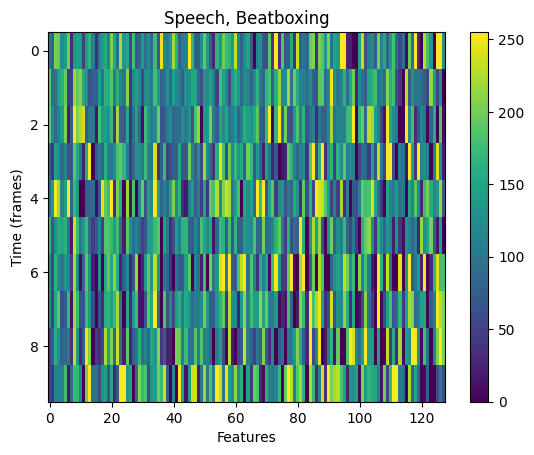

In [ ]:
import matplotlib.pyplot as plt

def visualize_embedding(embedding, label):
    plt.imshow(embedding, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(label)
    plt.xlabel('Features')
    plt.ylabel('Time (frames)')
    plt.show()

# Get a single example from the preprocessed dataset
for example in parsed_dataset.take(1):
    context, sequence = example
    raw_embedding = sequence['audio_embedding'].numpy()
    embedding1 = np.stack([np.frombuffer(em, dtype=np.uint8) for em in raw_embedding])
    
    labels = context['labels'].values.numpy()
    label_names = ', '.join(class_names[labels])

visualize_embedding(embedding1, label_names)


In [12]:
def preprocess_data(parsed_dataset, num_classes=527, maxlen=10):
    def preprocess(context_features, sequence_features):
        # Decode the audio_embedding
        embedding = tf.io.decode_raw(sequence_features['audio_embedding'], tf.uint8)
        embedding = tf.cast(embedding, tf.float32)
        
        # Normalize the audio_embedding
        embedding = tf.divide(embedding, 255.0)

        # Get the actual sequence length
        actual_seq_length = tf.shape(embedding)[0]

        # Reshape the audio_embedding
        embedding = tf.reshape(embedding, (actual_seq_length, 128))

        # Calculate the padding required to reach the maxlen
        padding_needed = maxlen - actual_seq_length
        padding = [[0, padding_needed], [0, 0]]

        # Pad the embedding
        embedding = tf.pad(embedding, padding)

        # Create a one-hot encoded label vector
        label = tf.sparse.to_dense(context_features['labels'], default_value=-1)
        label = tf.boolean_mask(label, label >= 0)
        label = tf.reduce_sum(tf.one_hot(label, num_classes), axis=0)

        return embedding, label

    # Map the preprocessing function to the dataset
    preprocessed_dataset = parsed_dataset.map(preprocess)

    # Extract input embeddings and labels from the dataset
    inputs, labels = zip(*list(preprocessed_dataset.as_numpy_iterator()))

    # Convert input embeddings to a list of numpy arrays
    inputs = [input for input in inputs]

    # Add an extra dimension to match the input shape of the model
    #inputs = np.expand_dims(inputs, axis=-1)

    # Convert the padded inputs and labels to a TensorFlow dataset
    return tf.data.Dataset.from_tensor_slices((np.array(inputs), np.array(labels)))


In [13]:
train_dataset = preprocess_data(parsed_dataset)
eval_dataset = preprocess_data(parsed_eval_dataset)


In [14]:
def get_input_shape(preprocessed_dataset):
    # Get one example from the preprocessed dataset
    one_example = next(iter(preprocessed_dataset))
    
    # The input shape should exclude the batch size, so we only take the shape starting from the first dimension
    input_shape = one_example[0].shape
    
    return input_shape


In [15]:
input_shape = get_input_shape(train_dataset)
print("Input shape:", input_shape)


Input shape: (10, 128)


In [ ]:
#Model 1
from tensorflow.keras.layers import BatchNormalization

def create_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv1D(64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.05))

    model.add(Conv1D(128, kernel_size=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.35))

    model.add(Dense(num_classes, activation='sigmoid'))

    return model


In [16]:
#model 2
from tensorflow.keras.layers import BatchNormalization

def create_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv1D(64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.05))

    model.add(Conv1D(128, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv1D(256, kernel_size=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv1D(512, kernel_size=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.35))

    model.add(Dense(num_classes, activation='sigmoid'))

    return model



In [ ]:
#Model 3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape

def create_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Reshape((*input_shape, 1), input_shape=input_shape))  # Add a Reshape layer to create the required shape for 2D convolution
    
    model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.15))

    model.add(Conv2D(512, kernel_size=(2, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.5))

    model.add(Conv2D(1084, kernel_size=(1, 1), activation='relu'))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='sigmoid'))

    return model


In [17]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Create a new model with fresh weights
model = create_model(input_shape, num_classes=527)

# Define the learning rate
learning_rate = 0.001  # Modify this value to adjust the learning rate

# Instantiate the optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 64)            8256      
                                                                 
 batch_normalization (BatchN  (None, 10, 64)           256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 128)            16512     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 128)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 4, 128)            0

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model with early stopping
history = model.fit(train_dataset.batch(32), epochs=100, validation_data=eval_dataset.batch(32), callbacks=[early_stopping_callback])


Epoch 1/100
4688/4688 [==============================] - 42s 6ms/step - loss: 0.0137 - accuracy: 0.6427 - val_loss: 0.0197 - val_accuracy: 0.3847
Epoch 2/100
4688/4688 [==============================] - 29s 6ms/step - loss: 0.0109 - accuracy: 0.6625 - val_loss: 0.0190 - val_accuracy: 0.3770
Epoch 3/100
4688/4688 [==============================] - 29s 6ms/step - loss: 0.0105 - accuracy: 0.6678 - val_loss: 0.0189 - val_accuracy: 0.3916
Epoch 4/100
4688/4688 [==============================] - 30s 6ms/step - loss: 0.0103 - accuracy: 0.6695 - val_loss: 0.0188 - val_accuracy: 0.3915
Epoch 5/100
4688/4688 [==============================] - 30s 6ms/step - loss: 0.0101 - accuracy: 0.6728 - val_loss: 0.0185 - val_accuracy: 0.3966
Epoch 6/100
4688/4688 [==============================] - 30s 6ms/step - loss: 0.0100 - accuracy: 0.6729 - val_loss: 0.0184 - val_accuracy: 0.3987
Epoch 7/100
4688/4688 [==============================] - 30s 6ms/step - loss: 0.0099 - accuracy: 0.6742 - val_loss: 0.0184 -

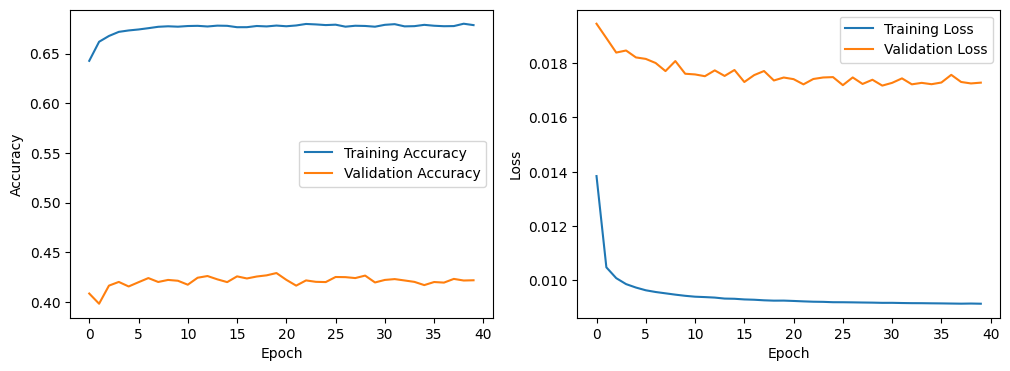

In [ ]:
#model 1
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)


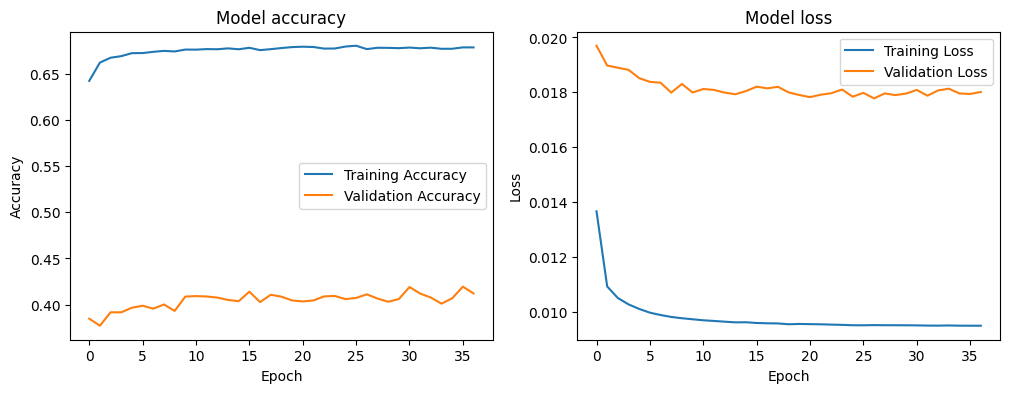

In [19]:
#model 2
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)


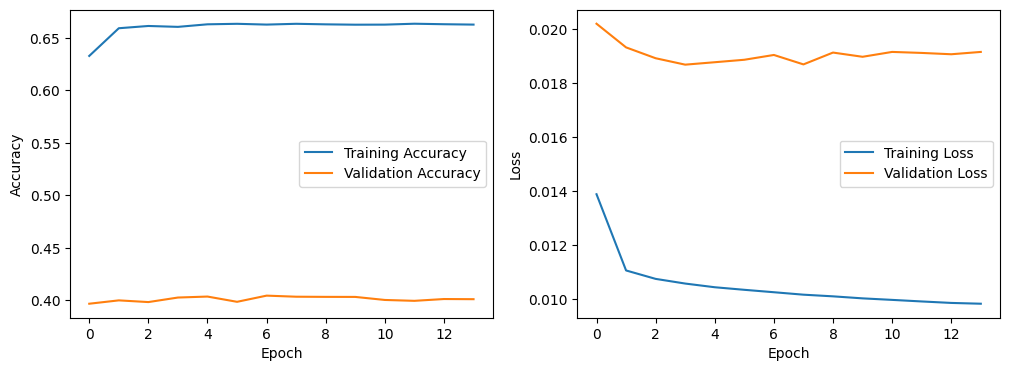

In [ ]:
#model 3
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)


#Save the model, for the GUI use

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = "/content/drive/My Drive/Colab Notebooks/Model 32.h5"
model.save(model_path)
